In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import time
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [8]:
cambridge_map = map_structure(city='Cambridge')

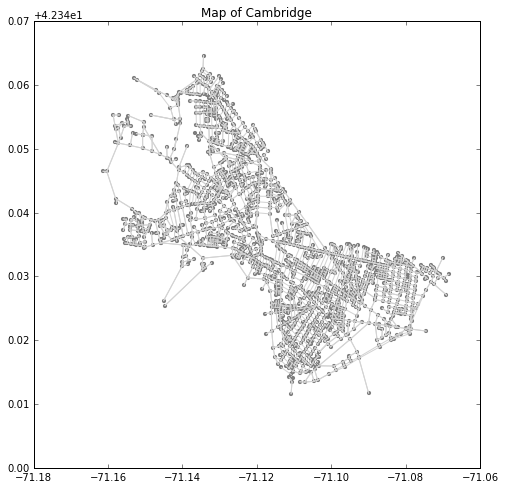

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [20]:
print 'number of accidents in Cambridge', np.sum([val.get_accidents() for key, val in cambridge_map.road_connections.iteritems()])

number of accidents in Cambridge 876


**San Francisco**

In [2]:
san_fran_map = map_structure(city='San Francisco')

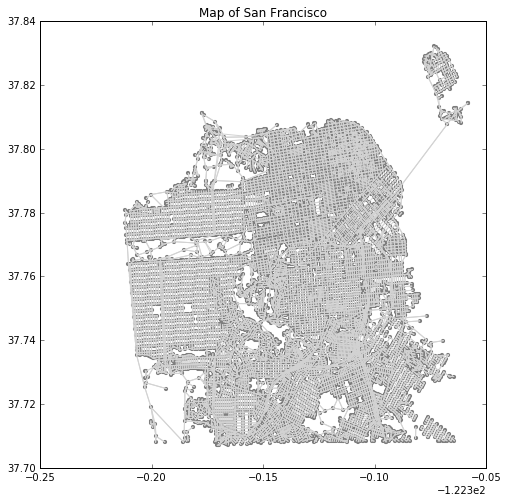

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

In [6]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [7]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

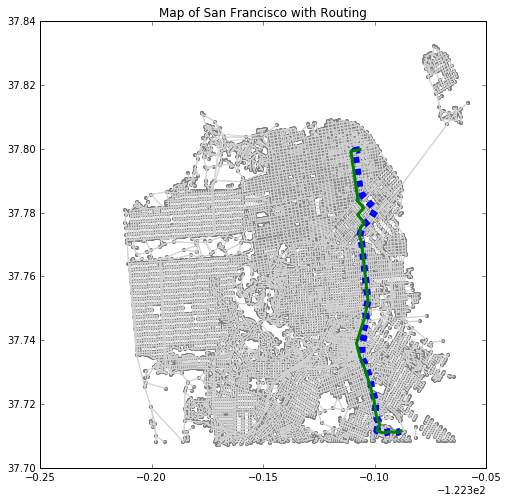

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [3]:
def sim(start, end, cost_fn, heuristic_fn, map_to_test):
    route, nodes_expanded = map_to_test.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = map_to_test.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([np.abs(map_to_test.road_connections[conn].delta_elevation) for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn, heuristic_fn, map_to_test=san_fran_map):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        try:
            start = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            euclid_dist = 0
            while (end.id == start.id) or ((euclid_dist < 0.02) or (euclid_dist > 0.15)):
                end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
                euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

            # under the null heuristic
            result0 = sim(start, end, cost_fn[0], heuristic_fn[0], map_to_test)

            # under the euclidean_heuristic heuristic
            result1 = sim(start, end, cost_fn[1], heuristic_fn[1], map_to_test)

            # under the combined_heuristic heuristic
            result2 = sim(start, end, cost_fn[2], heuristic_fn[2], map_to_test)
            
            euclidean_dist.append(euclid_dist)
            
            k = 0
            solution_nodes[k].append(result0[0])
            solution_route_distance[k].append(result0[1])
            solution_delta_elevation[k].append(result0[2])
            solution_nodes_expanded[k].append(result0[3])
            
            k = 1
            solution_nodes[k].append(result1[0])
            solution_route_distance[k].append(result1[1])
            solution_delta_elevation[k].append(result1[2])
            solution_nodes_expanded[k].append(result1[3])
            
            k = 2
            solution_nodes[k].append(result2[0])
            solution_route_distance[k].append(result2[1])
            solution_delta_elevation[k].append(result2[2])
            solution_nodes_expanded[k].append(result2[3])
        except:
            print 'problem', start, end
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

#watch out for this number. The larger it is the longer this will all take!!! (100 is MASSIVE)
nsim = 100

Basic road cost

In [14]:
# Cost function = get_road_cost ## I.e. simple road cost
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_road_cost, san_fran_map.get_road_cost]
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]

result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 51107000, x: -122.449544149, y: 37.7164723456 
Connections: set([5729000]) <Node> id: 50221000, x: -122.406071197, y: 37.7900062553 
Connections: set([6687000])
problem <Node> id: 50850000, x: -122.390807548, y: 37.7084083646 
Connections: set([11327000]) <Node> id: 21972000, x: -122.436672889, y: 37.7340401745 
Connections: set([3995000, 3030201, 3994000, 3029101])


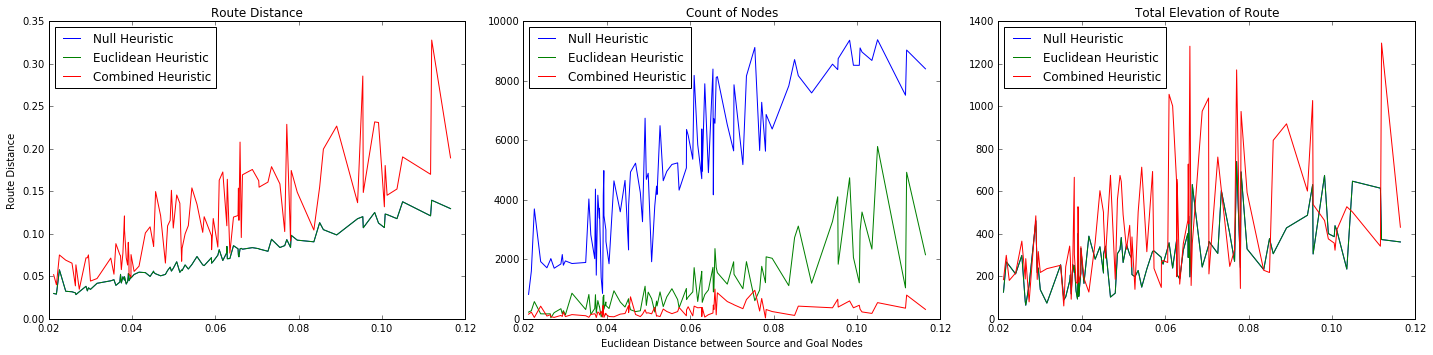

In [15]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)
solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost

In [16]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 51358000, x: -122.474036891, y: 37.7986189775 
Connections: set([19420000, 19744000, 19421000]) <Node> id: 51010000, x: -122.432163759, y: 37.7083165039 
Connections: set([3652101])
problem <Node> id: 21528000, x: -122.446371846, y: 37.7157279625 
Connections: set([11134000, 10059000, 10060000, 11135000]) <Node> id: 52117000, x: -122.394794689, y: 37.7081465826 
Connections: set([19225000])
problem <Node> id: 26175000, x: -122.443517047, y: 37.7605092095 
Connections: set([4581000, 8774201, 8773101]) <Node> id: 33679000, x: -122.426073527, y: 37.7093471089 
Connections: set([19955000, 11274000, 12939000, 11275000])


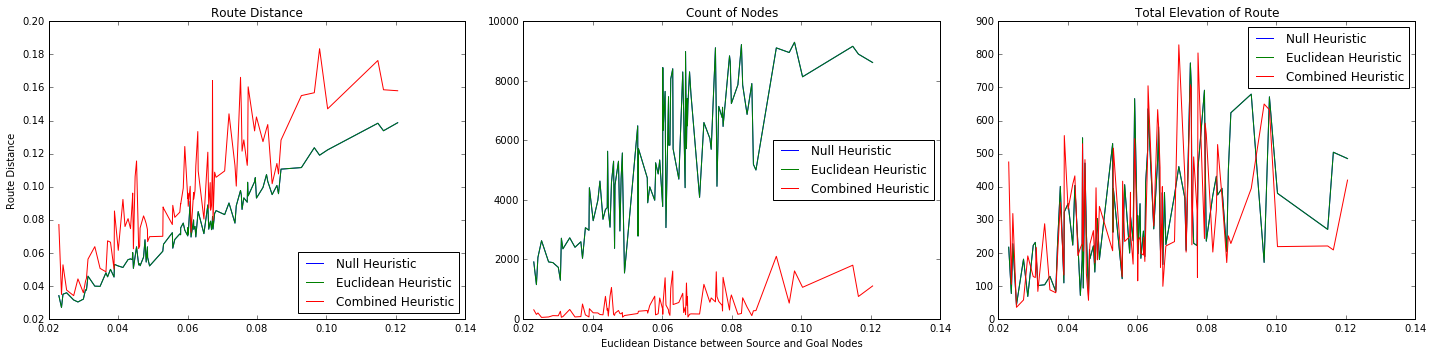

In [17]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost with Elevation

In [5]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]
cost_fn = [san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 51208000, x: -122.448736246, y: 37.7976198302 
Connections: set([19488000, 19487000]) <Node> id: 53052000, x: -122.358369442, y: 37.8143065877 
Connections: set([14243000])
problem <Node> id: 26803000, x: -122.441158202, y: 37.7831636703 
Connections: set([3200000, 6044202]) <Node> id: 52172000, x: -122.447423953, y: 37.7591921276 
Connections: set([12978000])
problem <Node> id: 50844000, x: -122.38422225, y: 37.7084503994 
Connections: set([9931000]) <Node> id: 21950000, x: -122.431241876, y: 37.7383569462 
Connections: set([5353000, 4794000, 5354000])


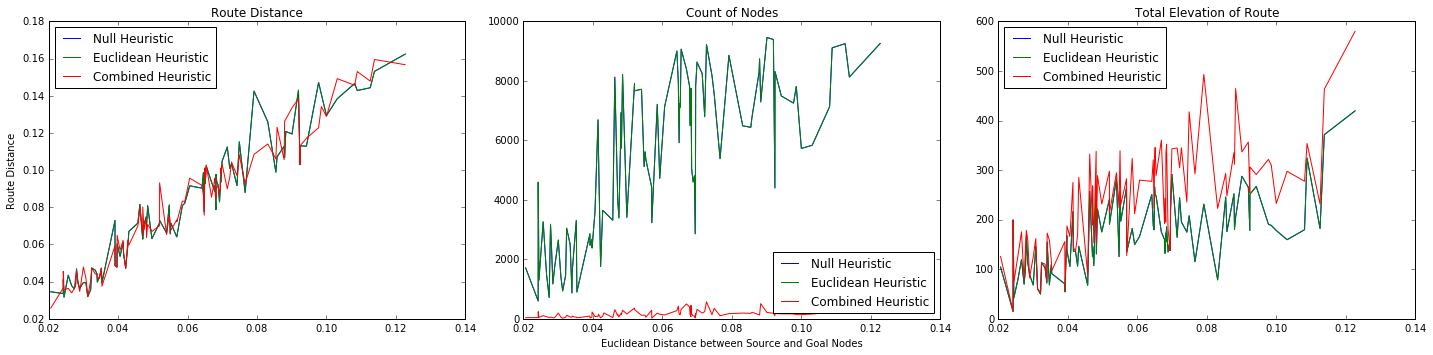

In [6]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

In [20]:
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost_with_elevation]
heuristic = [san_fran_map.null_heuristic, san_fran_map.null_heuristic, san_fran_map.null_heuristic]

result = execute_simulation(100, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

problem <Node> id: 51050000, x: -122.424463213, y: 37.7380803666 
Connections: set([3897000]) <Node> id: 32961000, x: -122.450020192, y: 37.751134853 
Connections: set([11947000, 2379000, 11946000])
problem <Node> id: 27082000, x: -122.461023124, y: 37.7652093364 
Connections: set([247000, 7085000, 246000, 7084000]) <Node> id: 50933000, x: -122.412104017, y: 37.7337807817 
Connections: set([3752000])
problem <Node> id: 51467000, x: -122.433976719, y: 37.7416147285 
Connections: set([1677000]) <Node> id: 50830000, x: -122.377555663, y: 37.7141228194 
Connections: set([5106000])
problem <Node> id: 50643000, x: -122.44387383, y: 37.7400123693 
Connections: set([3379000]) <Node> id: 25417000, x: -122.412283021, y: 37.7990957995 
Connections: set([8823000, 8824000, 6458000, 6457000])


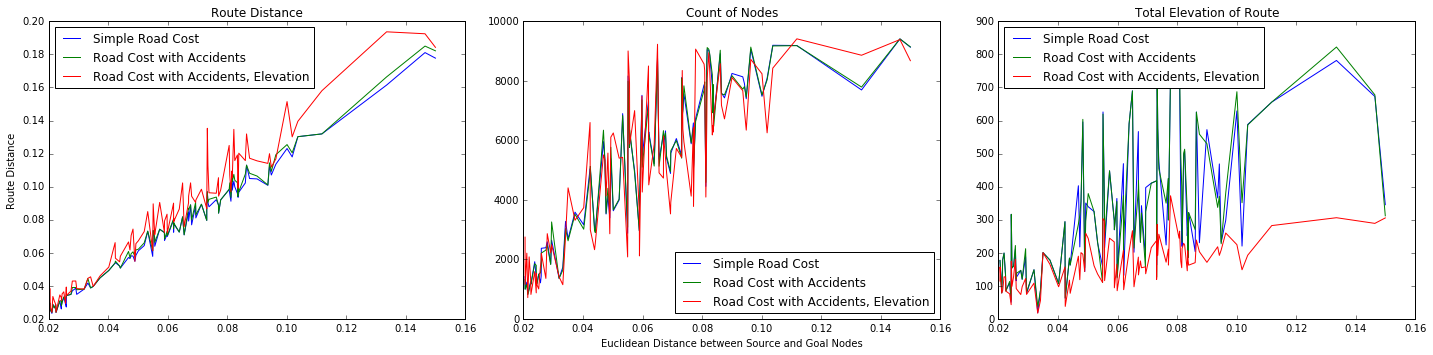

In [21]:
## Compare cost function 
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Simple Road Cost', 'Road Cost with Accidents', 'Road Cost with Accidents, Elevation']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam

In [6]:
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

route = cambridge_map.a_star_search(start, end, cambridge_map.get_road_cost, cambridge_map.null_heuristic)

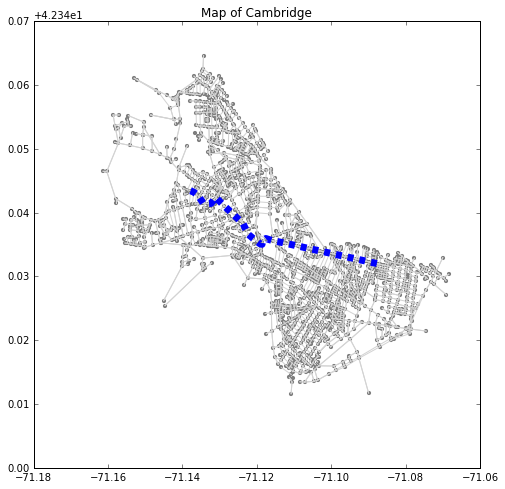

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([route['nodes']], ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [5]:
# define which map type you want to run
test_map = san

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

heuristic_fns = [test_map.null_heuristic, test_map.euclidean_heuristic, test_map.combined_heuristic]
times_annealing = []
times_k_beam = []
costs_annealing = []
costs_k_beam = []

for fn in heuristic_fns:
    timer = start - time.clock()
    node_annealing = test_map.simulated_annealing(
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_annealing = start - time.clock()
    times_annealing.append(timer_annealing)
    cost = np.sum([test_map.cost(p, node_annealing, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_annealing.append(cost)
    
    timer = start - time.clock()
    node_k_beam = test_map.k_beam_search(k=5,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_k_beam = start - time.clock()
    times_k_beam.append(timer_k_beam)
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_k_beam.append(cost)
# Sorry I am not sure why this is breaking by I am exhausted... :(

iteration  0 best cost 2560.68879626


AttributeError: 'tuple' object has no attribute 'id'

In [ ]:
# I think maybe a bar chart? Not sure

In [4]:
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

times = []
costs_k_beam = []
ks = np.linspace(5,35,10)

for k in ks:
    k = int(k)
    start = time.clock()
    node_k_beam = test_map.k_beam_search(k=k,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)

    timer = start - time.clock()
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    times.append(timer)
    costs.append(cost)
# same comment here

iteration  0 best cost 1951.20813454
iteration  1 best cost 1848.98002698
iteration  2 best cost 1709.5480261
iteration  3 best cost 1585.70198196


AttributeError: 'tuple' object has no attribute 'id'